# Grid algorithms for hierarchical models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

It is widely believed that grid algorithms are only practical for models with 1-3 parameters, or maybe 4-5 if you are careful.
[I've said so myself](https://allendowney.github.io/ThinkBayes2/chap19.html).

But recently I used a grid algorithm to solve the [emitter-detector problem](https://www.allendowney.com/blog/2021/09/05/emitter-detector-redux/), and along the way I noticed something about the structure of the problem: although the model has two parameters, the data only depend on one of them.
And that made it possible to evaluate the likelihood function, and update the model, very efficiently.

Then I realized that many hierarchical models have a similar structure: the data depend on a small number of parameters, which depend on a small number of hyperparameters.
I wondered whether the same method would generalize to more complex models, and it does.

As an example, in this notebook I'll use a logitnormal-binomial hierarchical model to solve a problem with two hyperparameters and 13 parameters, with a total run time that's not just practical; it's substantially faster than MCMC.




In [4]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [5]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [7]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [8]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [9]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

The problem I'll solve is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [10]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [11]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [12]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Solution with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [13]:
import pymc3 as pm
import theano.tensor as tt

def make_model():
    with pm.Model() as model:
        mu = pm.Normal('mu', 0, 2)
        sigma = pm.HalfNormal('sigma', sigma=1)
        xs = pm.LogitNormal('xs', mu=mu, sigma=sigma, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

CPU times: user 942 ms, sys: 55.3 ms, total: 997 ms
Wall time: 2.46 s


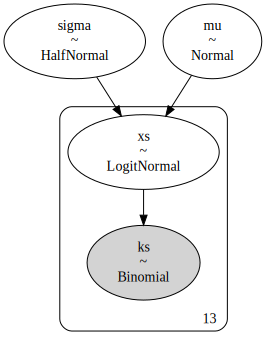

In [14]:
%time model = make_model()
pm.model_to_graphviz(model)

In [15]:
with model:
    pred = pm.sample_prior_predictive(1000)
    %time trace = pm.sample(500, target_accept=0.97)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9226247232017322, but should be close to 0.97. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9344801677356562, but should be close to 0.97. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9239547884156584, but should be close to 0.97. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 5.32 s, sys: 177 ms, total: 5.49 s
Wall time: 10.3 s


Here are the posterior distributions of the hyperparameters

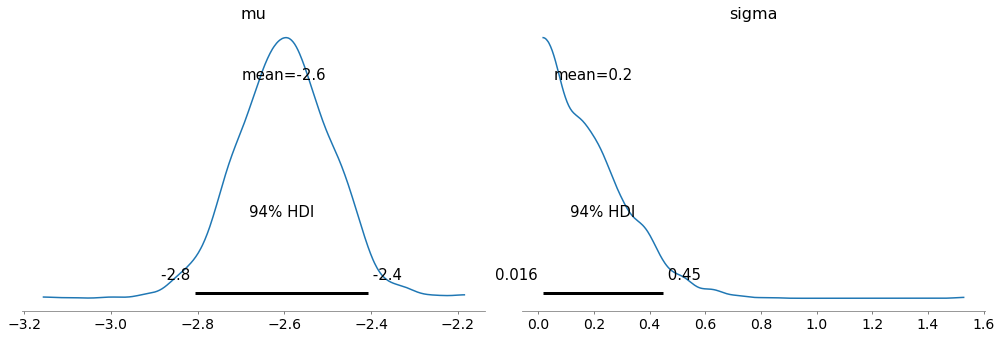

In [16]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['mu', 'sigma'])

And we can extract the posterior distributions of the xs.

In [17]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

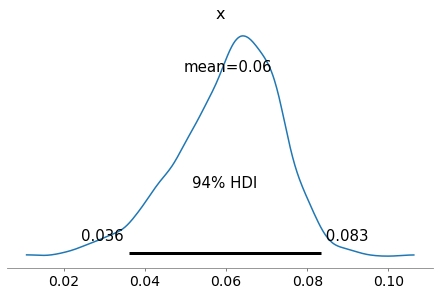

In [18]:
with model:
    az.plot_posterior(trace_xs[0])

## The grid priors

Now let's solve the same problem using a grid algorithm.
I'll use the same priors for the hyperparameters, approximated by a grid with about 100 elements in each dimension.

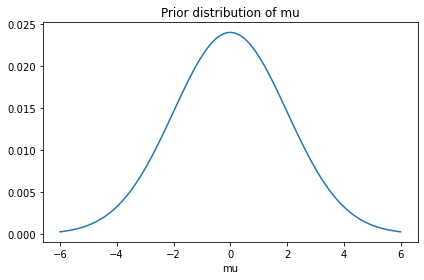

In [19]:
import numpy as np
from scipy.stats import norm

mus = np.linspace(-6, 6, 101)
ps = norm.pdf(mus, 0, 2)
prior_mu = make_pmf(ps, mus, 'mu')

prior_mu.plot()
decorate(title='Prior distribution of mu')

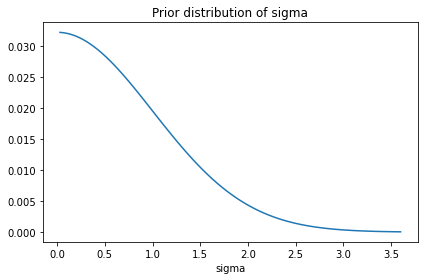

In [20]:
from scipy.stats import logistic

sigmas = np.linspace(0.03, 3.6, 90)
ps = norm.pdf(sigmas, 0, 1)
prior_sigma = make_pmf(ps, sigmas, 'sigma')

prior_sigma.plot()
decorate(title='Prior distribution of sigma')

The following cells confirm that these priors are consistent with the prior samples from PyMC.

2.6020852139652106e-18 -0.11862211139301673


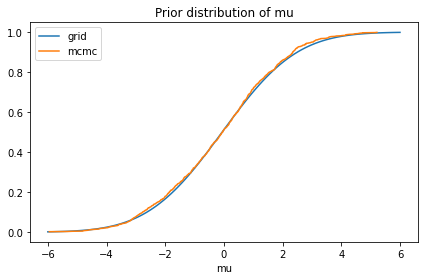

In [22]:
compare_cdf(prior_mu, pred['mu'])
decorate(title='Prior distribution of mu')

0.8033718951689776 0.7869635745294363


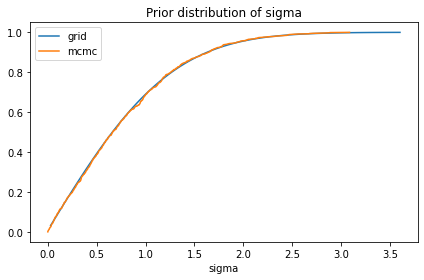

In [23]:
compare_cdf(prior_sigma, pred['sigma'])
decorate(title='Prior distribution of sigma')


## The joint distribution of hyperparameters

I'll use `make_joint` to make an array that represents the joint prior distribution of the hyperparameters.

In [24]:
def make_joint(prior_x, prior_y):
    X, Y = np.meshgrid(prior_x.ps, prior_y.ps, indexing='ij')
    hyper = X * Y
    return hyper

In [25]:
prior_hyper = make_joint(prior_mu, prior_sigma)
prior_hyper.shape

(101, 90)

Here's what it looks like.

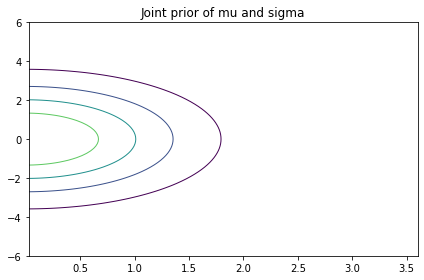

In [26]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, index=mus, columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## Joint prior of hyperparameters and x

Now we're ready to lay out the grid for x, which is the proportion we'll estimate for each hospital.

In [44]:
xs = np.linspace(0.01, 0.99, 99)
M, S, X = np.meshgrid(mus, sigmas, xs, indexing='ij')

For each pair of hyperparameters, we'll compute the distribution of `x`.

In [45]:
from scipy.special import logit

LO = logit(X)
LO.sum()

1.0733458566392073e-10

In [46]:
from scipy.stats import norm

%time normpdf = norm.pdf(LO, M, S)
normpdf.sum()

CPU times: user 30.4 ms, sys: 4.83 ms, total: 35.2 ms
Wall time: 34 ms


71718.84185391405

We can speed this up by computing skipping the terms that don't depend on x

In [47]:
%%time

z = (LO-M) / S
normpdf = np.exp(-z**2/2)

CPU times: user 13.5 ms, sys: 184 µs, total: 13.7 ms
Wall time: 11.9 ms


Now we need to normalize each distribution of `x`.

In [49]:
totals = normpdf.sum(axis=2)
totals.sum()

319605.2624567877

In [50]:
shape = totals.shape + (1,)
totals = totals.reshape(shape)

out = np.zeros_like(normpdf)
normpdf = np.divide(normpdf, totals,
                    out=out, where=(totals!=0))
normpdf.sum()

9083.999999999998

The result is an array that contains the distribution of `x` for each pair of hyperparameters.

Now, to get the prior distribution, we multiply through by the joint distribution of the hyperparameters.

In [33]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = normpdf * hyper.reshape(shape)

    return prior

In [34]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 1.97 ms, sys: 727 µs, total: 2.7 ms
Wall time: 1.46 ms


0.9999377812780397

The result is a 3-D array that represents the joint prior distribution of `mu`, `sigma`, and `x`.

To check that it is correct, I'll extract the marginal distributions and compare them to the priors.

In [35]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

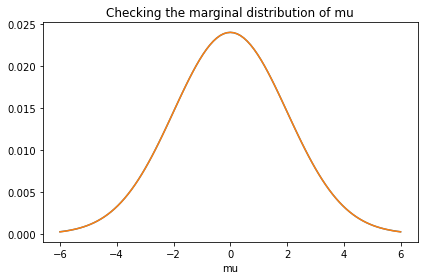

In [36]:
prior_mu.plot()
marginal_mu = Pmf(marginal(prior, 0), mus)
marginal_mu.plot()
decorate(title='Checking the marginal distribution of mu')

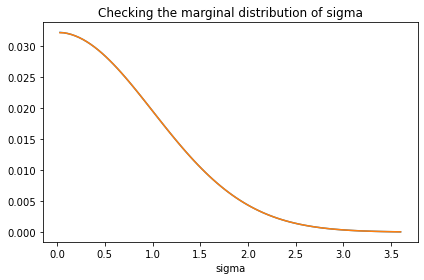

In [37]:
prior_sigma.plot()
marginal_sigma = Pmf(marginal(prior, 1), sigmas)
marginal_sigma.plot()
decorate(title='Checking the marginal distribution of sigma')

We didn't compute the prior distribution of `x` explicitly; it follows from the distribution of the hyperparameters. But we can extract the prior marginal of `x` from the joint prior.

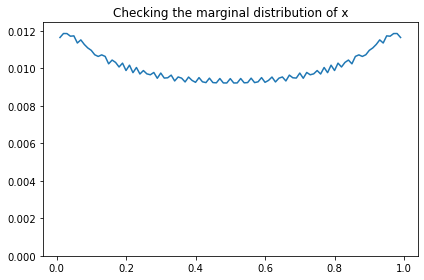

In [39]:
marginal_x = Pmf(marginal(prior, 2), xs)
marginal_x.plot()
decorate(title='Checking the marginal distribution of x',
         ylim=[0, np.max(marginal_x) * 1.05])

And compare it to the prior sample from PyMC.

In [42]:
pred_xs = pred['xs'].transpose()
pred_xs.shape

(13, 1000)

0.4999688906390199 0.4813414567157059


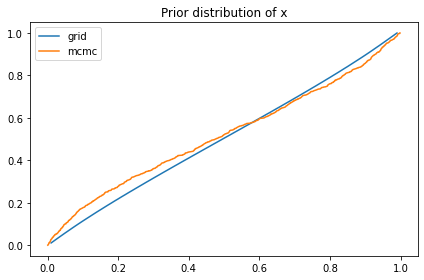

In [43]:
compare_cdf(marginal_x, pred_xs[0])
decorate(title='Prior distribution of x')

TODO: Not quite...

In addition to the marginals, we'll also find it useful to extract the joint marginal distribution of the hyperparameters.

In [61]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [62]:
hyper = get_hyper(prior)

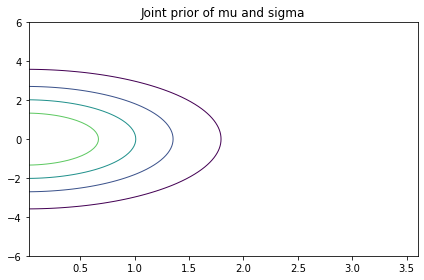

In [63]:
plot_contour(pd.DataFrame(hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## The Update

The likelihood of the data only depends on `x`, so we can compute it like this.

In [64]:
from scipy.stats import binom

data_k = data_ks[0]
data_n = data_ns[0]

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(99,)

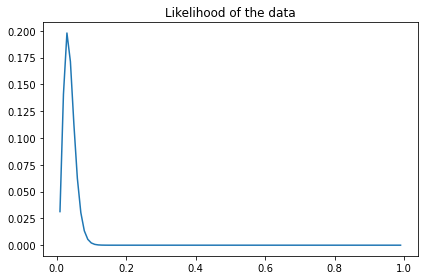

In [65]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

And here's the update.

In [66]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)
    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [67]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 4.68 ms, sys: 251 µs, total: 4.93 ms
Wall time: 3.28 ms


## Serial updates

At this point we can do an update based on a single hospital, but how do we update based on all of the hospitals.

As a step toward the right answer, I'll start with a wrong answer, which is to do the updates in series.

After each update, we extract the posterior distribution of the hyperparameters and use it to create the prior for the next update.

At the end, the posterior distribution of hyperparameters is correct, and the marginal posterior of `x` for the *last* hospital is correct, but the other marginals are wrong because they do not take into account data from subsequent hospitals.

In [68]:
def multiple_updates(prior, ns, ks):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [69]:
%time posterior = multiple_updates(prior, data_ns, data_ks)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 73.6 ms, sys: 3.68 ms, total: 77.3 ms
Wall time: 72.4 ms


Here are the posterior distributions of the hyperparameters, compared to the results from PyMC.

-2.644090621998822 -2.6003611594733163


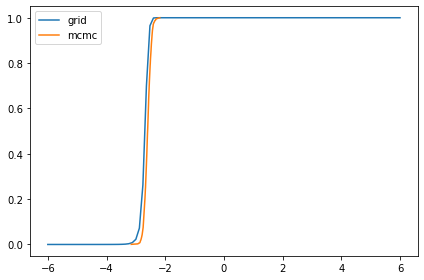

In [72]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace['mu'])

0.18756417735873676 0.19744706876570386


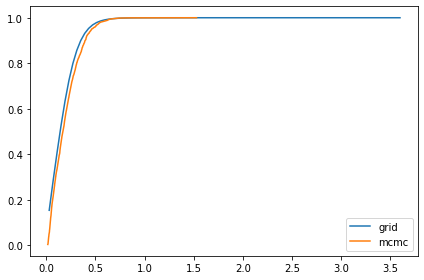

In [73]:
marginal_sigma = Pmf(marginal(posterior, 1), sigmas)
compare_cdf(marginal_sigma, trace['sigma'])

0.07347699925954573 0.0742470536826578


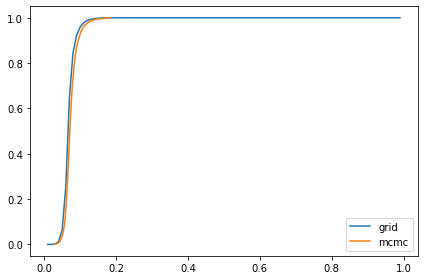

In [75]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace_xs[-1])

## Parallel updates

Doing serial updates is not quite right, but it gives us an insight.

Suppose we start with a uniform distribution for the hyperparameters and do an update with data from one hospital. If we extract the posterior joint distribution of the hyperparameters, what we get is the likelihood function associated with one dataset.

The following function computes these likelihood functions and saves them in an array called `hyper_likelihood`.

In [78]:
def compute_hyper_likelihood(ns, ks):
    shape = ns.shape + mus.shape + sigmas.shape
    hyper_likelihood = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = normpdf * like_x
        hyper_likelihood[i] = get_hyper(posterior)
    return hyper_likelihood

In [79]:
%time hyper_likelihood = compute_hyper_likelihood(data_ns, data_ks)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 32 ms, sys: 1.37 ms, total: 33.4 ms
Wall time: 29.7 ms


We can multiply this out to get the product of the likelihoods.

In [81]:
like_hyper_all = hyper_likelihood.prod(axis=0)
like_hyper_all.sum()

1.7333788105620214e-14

This is useful because it provides an efficient way to compute the marginal posterior distribution of `x` for any hospital.
Here's an example.

In [82]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

Suppose we did the updates serially and saved this hospital for last.
The prior distribution for the final update would reflect the updates from all previous hospitals, which we can compute by dividing out `hyper_likelihood[i]`.

In [93]:
def divide(x, y):
    out = np.zeros_like(x)
    return np.divide(x, y, out=out, where=(y!=0))    

In [94]:
out = np.zeros_like(prior_hyper)
hyper_i = divide(prior_hyper * like_hyper_all, hyper_likelihood[i])
hyper_i.sum()

4.4360036985111153e-17

In [95]:
prior_i = make_prior(hyper_i) 

In [96]:
posterior_i = update(prior_i, data)

And we can confirm that the results are similar to the results from PyMC.

In [97]:
marginal_mu = Pmf(marginal(posterior_i, 0), mus)
marginal_sigma = Pmf(marginal(posterior_i, 1), sigmas)
marginal_x = Pmf(marginal(posterior_i, 2), xs)

-2.6440906219988225 -2.6003611594733163


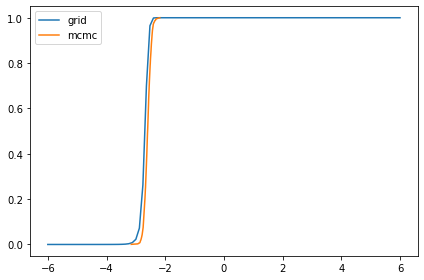

In [98]:
compare_cdf(marginal_mu, trace['mu'])

0.1875641773587368 0.19744706876570386


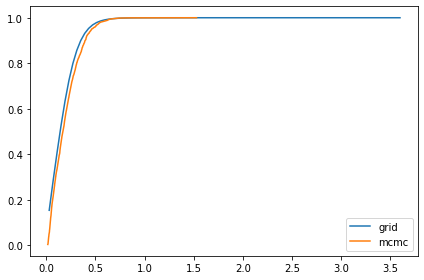

In [99]:
compare_cdf(marginal_sigma, trace['sigma'])

0.07264675600929857 0.07275793536970608


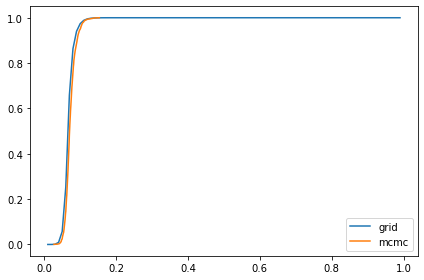

In [100]:
compare_cdf(marginal_x, trace_xs[i])

## Compute all marginals

In [101]:
def compute_all_marginals(ns, ks):
    prior = prior_hyper * like_hyper_all
    
    for i, data in enumerate(zip(ns, ks)):
        n, k = data
        hyper_i = divide(prior, hyper_likelihood[i])
        prior_i = make_prior(hyper_i) 
        posterior_i = update(prior_i, data)
        marginal_x = Pmf(marginal(posterior_i, 2), xs)
        marginal_x.make_cdf().plot()
        print(i, n, k/n, marginal_x.mean())

0 129 0.031007751937984496 0.061691124682509216
1 35 0.02857142857142857 0.06687757905769878
2 228 0.07894736842105263 0.07286077445807708
3 84 0.08333333333333333 0.07264675600929857
4 291 0.08247422680412371 0.07445530188083078
5 270 0.05925925925925926 0.06638456420001479
6 46 0.13043478260869565 0.07779608423811295
7 293 0.06484641638225255 0.06816628050749017
8 241 0.06224066390041494 0.06753370949786361
9 105 0.12380952380952381 0.0817899721534193
10 353 0.0708215297450425 0.07027137338278386
11 250 0.044 0.06178804646054184
12 41 0.0975609756097561 0.07347699925954575
CPU times: user 205 ms, sys: 152 ms, total: 356 ms
Wall time: 153 ms


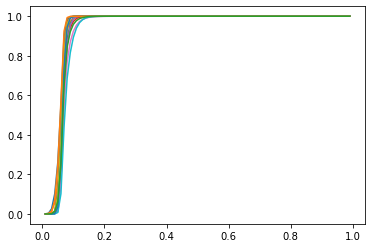

In [103]:
%time compute_all_marginals(data_ns, data_ks)